# 第6章 圧縮性流れの数値計算法その1（システム方程式の数値計算法）

## 6.2 高解像度風上法

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
jmax = 101
dt = 0.002

In [3]:
gamma = 1.4

In [4]:
PI = 1.0
RHOI = 1.0
UI = 0.0

PE = 0.1
RHOE = 0.1
UE = 0.0

In [5]:
xmin, xmid, xmax = 0.0, 0.5, 1.0
x = np.linspace(xmin, xmax, jmax)

dx = (xmax - xmin) / (jmax - 1)

dtdx = dt / dx

### Roeスキームによる計算

In [6]:
def init():
    Q = np.zeros([jmax, 3])

    Q[x <= xmid, 0] = RHOI
    Q[x <= xmid, 1] = RHOI * UI
    Q[x <= xmid, 2] = (PI / (gamma - 1.0) + 0.5 * RHOI * UI ** 2)

    Q[x > xmid, 0] = RHOE
    Q[x > xmid, 1] = RHOE * UE
    Q[x > xmid, 2] = (PE / (gamma - 1.0) + 0.5 * RHOE * UE ** 2)

    return Q

In [7]:
def calc_CFL(Q):
    rho, rhou, e = Q[:, 0], Q[:, 1], Q[:, 2]
    
    u = rhou / rho
    p = (gamma - 1.0) * (e - 0.5 * rho * u ** 2)
    
    c = np.sqrt(gamma * p / rho)
    sp = c + np.abs(u)
    return max(sp) * dtdx   

In [8]:
def Roe_flux(QL, QR, E):
    for j in range(jmax - 1):        
        rhoL, uL, pL = QL[    j, 0], QL[    j, 1], QL[    j, 2]
        rhoR, uR, pR = QR[j + 1, 0], QR[j + 1, 1], QR[j + 1, 2]
        
        rhouL = rhoL * uL
        rhouR = rhoR * uR

        eL = pL / (gamma - 1.0) + 0.5 * rhoL * uL ** 2
        eR = pR / (gamma - 1.0) + 0.5 * rhoR * uR ** 2

        HL = (eL + pL) / rhoL
        HR = (eR + pR) / rhoR
        
        cL = np.sqrt((gamma - 1.0) * (HL - 0.5 * uL ** 2))
        cR = np.sqrt((gamma - 1.0) * (HR - 0.5 * uR ** 2))
                
        # Roe平均 式(6.38)        
        sqrhoL = np.sqrt(rhoL)
        sqrhoR = np.sqrt(rhoR)

        rhoAVE = sqrhoL * sqrhoR
        uAVE = (sqrhoL * uL + sqrhoR * uR) / (sqrhoL + sqrhoR)
        HAVE = (sqrhoL * HL + sqrhoR * HR) / (sqrhoL + sqrhoR) 
        cAVE = np.sqrt((gamma - 1.0)* (HAVE - 0.5 * uAVE ** 2))
        eAVE = rhoAVE * (HAVE - cAVE ** 2 / gamma)
        
        dQ = np.array([rhoR - rhoL, rhoR * uR - rhoL * uL, eR - eL])
        
        Lambda = np.diag([np.abs(uAVE - cAVE), 
                                              np.abs(uAVE), 
                                                          np.abs(uAVE + cAVE)])
        
        b1 = 0.5 * (gamma - 1.0) * uAVE ** 2 / cAVE ** 2
        b2 = (gamma - 1.0) / cAVE ** 2

        R = np.array([[               1.0,              1.0,                1.0],
                      [       uAVE - cAVE,             uAVE,        uAVE + cAVE],
                      [HAVE - uAVE * cAVE, 0.5 * uAVE ** 2, HAVE + uAVE * cAVE]])
        
        Rinv = np.array([[0.5 * (b1 + uAVE / cAVE), -0.5 * (b2 * uAVE + 1/cAVE), 0.5 * b2],
                         [                1.0 - b1,                 b2 * uAVE,      -b2],
                         [0.5 * (b1 - uAVE / cAVE), -0.5 * (b2 * uAVE - 1/cAVE), 0.5 * b2]])
        
        AQ = R @ Lambda @ Rinv @ dQ
        
        
        EL = np.array([rhoL * uL, pL + rhouL * uL, (eL + pL) * uL])
        ER = np.array([rhoR * uR, pR + rhouR * uR, (eR + pR) * uR])
        
        E[j] = 0.5 * (ER + EL - AQ) # 式(6.43)

In [9]:
def minmod(x, y):
    sgn = np.sign(x)
    return sgn * np.maximum(np.minimum(np.abs(x), sgn * y), 0.0)

In [10]:
def MUSCL(Q, order, kappa):
    # 基本変数で内挿する
    
    rho, rhou, e = Q[:, 0], Q[:, 1], Q[:, 2]
    
    Q[:, 1] = rhou / rho  # u
    Q[:, 2] = (gamma - 1.0) * (e - 0.5 * rho * Q[:, 1] ** 2) # p
    
    if order == 2 or order == 3:
        # 2nd / 3rd order & minmod limitter
        dQ = np.zeros([jmax, 3])
        for j in range(jmax - 1):
            dQ[j] = Q[j+1] - Q[j]
        
        b = (3.0 - kappa) / (1.0 - kappa) # 式(2.74)
        
        Dp = np.zeros([jmax, 3])
        Dm = np.zeros([jmax, 3])
        for j in range(1, jmax - 1):
            Dp[j] = minmod(dQ[j]  , b * dQ[j - 1]) # 式(2.73a)
            Dm[j] = minmod(dQ[j-1], b * dQ[j])     # 式(2.73b)
        Dp[0] = Dp[1]
        Dm[0] = Dm[1]
        
        QL = Q.copy()
        QR = Q.copy()
        for j in range(1, jmax - 1):
            QL[j] += 0.25 * ((1.0 - kappa) * Dp[j] + (1.0 + kappa) * Dm[j]) # 式(2.72a)
            QR[j] -= 0.25 * ((1.0 + kappa) * Dp[j] + (1.0 - kappa) * Dm[j]) # 式(2.72b)
        
    else:
        # 1st order
        QL = Q.copy()
        QR = Q.copy()

    return QL, QR

In [11]:
def Roe_FDS(Q, order, kappa, nmax, print_interval = 2):
    E = np.zeros([jmax, 3])

    for n in range(nmax):
        if n % print_interval == 0:
            print(f'n = {n : 4d} : CFL = {calc_CFL(Q) : .4f}')

        Qold = Q.copy()
        
        coefs = [0.5, 1.0]
        for coef in coefs:
            QL, QR = MUSCL(Qold, order, kappa)
        
            Roe_flux(QL, QR, E)
            for j in range(1, jmax - 1):
                Qold[j] = Q[j] - coef * dtdx * (E[j] - E[j-1])
            
            Qold[0] = Q[0]
            Qold[-1] = Q[-1]
    
        Q[:] = Qold[:]

In [12]:
nmax = 100
print_interval = 4

order = 2

# -1  = 2nd order fully upwind, 
# 0   = 2nd order upwind biased
# 1/3 = 3rd order upwind biased
kappa = 0

Q = init()
Roe_FDS(Q, order, kappa, nmax, print_interval)

n =    0 : CFL =  0.2366
n =    4 : CFL =  0.4262
n =    8 : CFL =  0.4362
n =   12 : CFL =  0.4645
n =   16 : CFL =  0.4733
n =   20 : CFL =  0.4754
n =   24 : CFL =  0.4790
n =   28 : CFL =  0.4803
n =   32 : CFL =  0.4822
n =   36 : CFL =  0.4810
n =   40 : CFL =  0.4800
n =   44 : CFL =  0.4799
n =   48 : CFL =  0.4792
n =   52 : CFL =  0.4792
n =   56 : CFL =  0.4791
n =   60 : CFL =  0.4787
n =   64 : CFL =  0.4787
n =   68 : CFL =  0.4785
n =   72 : CFL =  0.4784
n =   76 : CFL =  0.4784
n =   80 : CFL =  0.4781
n =   84 : CFL =  0.4780
n =   88 : CFL =  0.4779
n =   92 : CFL =  0.4779
n =   96 : CFL =  0.4778


### 厳密解の計算

#### 初期化

In [13]:
Pext = np.zeros([jmax, 3])
Qext = np.zeros([jmax, 3])

GUESS = 1.0
FINC = 0.01
itemax1 = 5000
itemax2 = 500

CI = np.sqrt(gamma * PI / RHOI)
CE = np.sqrt(gamma * PE / RHOE)
P1P5 = PI / PE

GAMI = 1.0 / gamma
GAMF = (gamma - 1.0) / (2.0 * gamma)
GAMF2 = (gamma + 1.0) / (gamma - 1.0)
GAMFI = 1.0 / GAMF

for it1 in range(itemax1):
    for it2 in range(itemax2):
        SQRT1 = (gamma - 1.0) * (CE / CI) * (GUESS - 1.0)
        SQRT2 = np.sqrt(2.0 * gamma * (2.0 * gamma + (gamma + 1.0) * (GUESS - 1.0)))
        FUN = GUESS * (1.0 - (SQRT1 / SQRT2)) ** (-GAMFI)
        DIF = P1P5 - FUN
        
        if np.abs(DIF) <= 0.000002:
            break
        
        if DIF >= 0.0:
            GUESS += FINC
        else:
            GUESS -= FINC
            FINC = 0.5 * FINC
    else:
        continue
    
    break

P4P5 = GUESS
P4 = PE * P4P5
P3P1 = P4P5 / P1P5
P3 = P3P1 * PI

R4R5 = (1.0 + GAMF2 * P4P5) / (GAMF2 + P4P5)
RHO4 = RHOE * R4R5
U4 = CE * (P4P5 - 1.0) * np.sqrt(2.0 * GAMI / ((gamma + 1.0) * P4P5 + (gamma - 1.0)))
C4 = np.sqrt(gamma * P4 / RHO4)

R3R1 = P3P1 ** GAMI
RHO3 = RHOI * R3R1 
U3 = 2.0 * CI / (gamma - 1.0) * (1.0 - P3P1 ** GAMF)
C3 = np.sqrt(gamma * P3 / RHO3)
CS =  CE * np.sqrt(0.5 * ((gamma - 1.0) * GAMI + (gamma + 1.0) * GAMI * P4 / PE))

#### 計算

In [14]:
TOT = 0.0
EPST = 1.0e-14
for n in range(nmax):
    TOT = TOT + dt
    rad = dt / dx
    
    x1 = xmid - CI * TOT
    x2 = xmid - (CI - 0.5 * (gamma + 1.0) * U3) * TOT
    x3 = xmid + U3 * TOT
    x4 = xmid + CS * TOT
    
    for j in range(jmax):
        xx = x[j]
        if xx <= x1:
            Qext[j, 0] = RHOI
            Qext[j, 1] = RHOI * UI
            Qext[j, 2] = PI / (gamma - 1.0) + 0.5 * UI * Qext[j, 1]
            Pext[j] = PI
        elif xx <= x2:
            UT = UI + (U3 - UI) / ((x2 - x1) + EPST) * ((xx - x1) + EPST)
            RTRI = (1.0 - 0.5 * (gamma - 1.0) * UT / CI) ** (2.0 / (gamma - 1.0))
            RT = RHOI * RTRI
            PT = RTRI ** gamma * PI
            Qext[j, 0] = RT
            Qext[j, 1] = RT * UT
            Qext[j, 2] = PT / (gamma - 1.0) + 0.5 * UT * Qext[j, 1]
            Pext[j] = PT
        elif xx <= x3:
            Qext[j, 0] = RHO3
            Qext[j, 1] = RHO3 * U3
            Qext[j, 2] = P3 / (gamma - 1.0) + 0.5 * U3 * Qext[j, 1]
            Pext[j] = P3
        elif xx <= x4:
            Qext[j, 0] = RHO4
            Qext[j, 1] = RHO4 * U4
            Qext[j, 2] = P4 / (gamma - 1.0) + 0.5 * U4 * Qext[j, 1]
            Pext[j] = P4
        else:
            Qext[j, 0] = RHOE
            Qext[j, 1] = RHOE * UE
            Qext[j, 2] = PE / (gamma - 1.0) + 0.5 * UE * Qext[j, 1]
            Pext[j] = PE            

### 結果の可視化

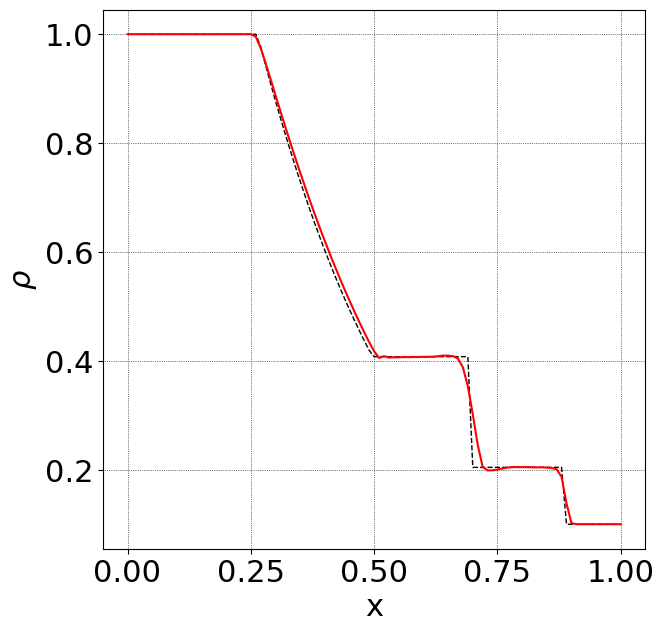

In [15]:
plt.figure(figsize=(7,7), dpi=100) # グラフのサイズ
plt.rcParams["font.size"] = 22 # グラフの文字サイズ
plt.plot(x, Qext[:,0], color='black', linewidth = 1.0, linestyle = 'dashed', label = 'Analytical')
plt.plot(x, Q[:,0], color='red', linewidth = 1.5, label = 'Numerical')
plt.grid(color='black', linestyle='dotted', linewidth=0.5)
plt.xlabel('x')
plt.ylabel(r'$\rho$')
#plt.legend()
plt.show()

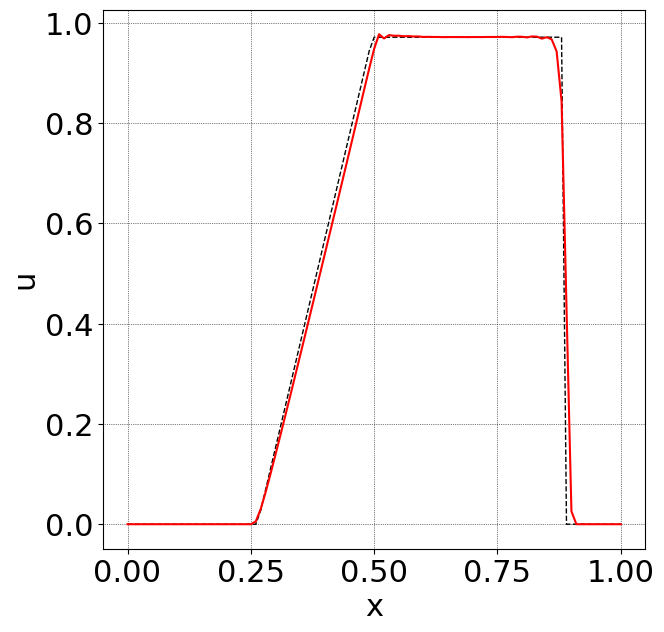

In [16]:
plt.figure(figsize=(7,7), dpi=100) # グラフのサイズ
plt.rcParams["font.size"] = 22 # グラフの文字サイズ
plt.plot(x, Qext[:,1]/Qext[:,0], color='black', linewidth = 1.0, linestyle = 'dashed', label = 'Analitical')
plt.plot(x, Q[:,1]/Q[:,0], color='red', linewidth = 1.5, label = 'Numerical')
plt.grid(color='black', linestyle='dotted', linewidth=0.5)
plt.xlabel('x')
plt.ylabel('u')
#plt.legend()
plt.show()

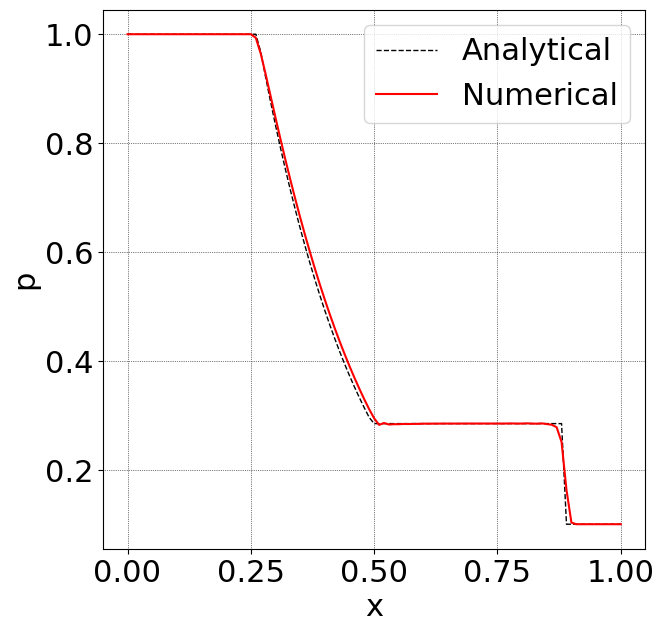

In [17]:
plt.figure(figsize=(7,7), dpi=100) # グラフのサイズ
plt.rcParams["font.size"] = 22 # グラフの文字サイズ
yext = (gamma - 1.0) * (Qext[:,2] - 0.5 * Qext[:,1] ** 2 / Qext[:,0])
y = (gamma - 1.0) * (Q[:,2] - 0.5 * Q[:,1] ** 2 / Q[:,0])
plt.plot(x, yext, color='black', linewidth = 1.0, linestyle = 'dashed',label = 'Analytical')
plt.plot(x, y, color='red', linewidth = 1.5,  label = 'Numerical')
plt.grid(color='black', linestyle='dotted', linewidth=0.5)
plt.xlabel('x')
plt.ylabel('p')
plt.legend()
plt.show()